In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 06: Base Model Descriptives
 * Compare the results for Friedman's H, ALE, and Shapley.  
 * Get some descriptive plots relating to term and interest rate

*This script takes about 1 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
import sklearn as sk
import matplotlib as mpl
import scipy
import random
from matplotlib.ticker import FormatStrFormatter, PercentFormatter
from sklearn.inspection import partial_dependence

In [3]:
from interactions_package.interactions_package import ip_plot

In [4]:
ip_plot.plot_defaults()

## Import Data

##### Predictors

In [5]:
predictor_features = pd.read_csv(Path(setup.temp_path) \
                                 .joinpath('01_REPORT_predictor_features.csv'))['feature'].tolist()

##### Dataset - train, test, and sampled train

In [6]:
test_df = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_test.parquet'))
train_df = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_train.parquet'))

In [7]:
train_samp_df = pd.read_parquet(Path(setup.temp_path) \
                                .joinpath('03_DATA_combined_base_train_samp.parquet')) 

##### Model

In [8]:
with open(Path(setup.temp_path).joinpath('02_MODEL_base_gc.pkl'), 'rb') as pi:
    base_model = pickle.load(pi)

##### Permutation importances

In [9]:
perm_importance_df = pd.read_csv(Path(setup.temp_path).joinpath('02_DATA_importance_perturb.csv'))

##### Friedman's H Scores

In [10]:
h_comb = pd.read_csv(Path(setup.temp_path).joinpath('03_DATA_h_scores.csv'))

##### 2-Way ALE Mean Abs

In [11]:
ale_mean_abs = pd.read_csv(Path(setup.temp_path).joinpath('04_DATA_ale_magnitudes_2way.csv'))

##### Shapley Interaction Mean Abs

In [12]:
shap_mean_abs = pd.read_csv(Path(setup.temp_path).joinpath('05_DATA_shap_mean_abs.csv'))

## Compare Ranks for the Three Methods

##### Align ranks and save table

In [13]:
h_comb['rank'] = h_comb['h_score'].rank(method='first', ascending=False) 
h_comb = h_comb.rename(columns={'h_score':'score'})

In [14]:
ale_mean_abs['rank'] = ale_mean_abs['abs_mean'].rank(method='first', ascending=False)
ale_mean_abs = ale_mean_abs.rename(columns={'abs_mean':'score'})

In [15]:
shap_mean_abs_int = shap_mean_abs[shap_mean_abs['feat_1'] != shap_mean_abs['feat_2']] \
    .copy() \
    .rename(columns={'shap_mean_abs':'score'})
shap_mean_abs_int['rank'] = shap_mean_abs_int['score'].rank(method='first', ascending=False)

In [16]:
rank_comb = h_comb[['rank', 'score', 'label']] \
    .merge(ale_mean_abs[['rank', 'score', 'label']], how='outer', on='rank',
           suffixes=('_h', '_ale')) \
    .merge(shap_mean_abs_int[['rank', 'score', 'label']], how='outer', on='rank') \
    .rename(columns={'score':'score_shap', 'label':'label_shap'})

In [17]:
rank_comb.head()

,rank,score_h,label_h,score_ale,label_ale,score_shap,label_shap
0,1.0,0.159343,loan_amnt:verification_status,0.004654,annual_inc:sec_app_fico_range_low,0.029502,int_rate:term
1,2.0,0.146755,loan_amnt:revol_bal,0.004026,int_rate:home_ownership__RENT,0.021683,int_rate:sec_app_fico_range_low
2,3.0,0.136924,term:home_ownership__RENT,0.003251,int_rate:term,0.014491,int_rate:loan_amnt
3,4.0,0.134237,loan_amnt:annual_inc,0.003209,annual_inc:fico_range_low,0.011650,int_rate:mort_acc
4,5.0,0.127820,term:sec_app_fico_range_low,0.002340,int_rate:annual_inc,0.010035,int_rate:annual_inc


In [18]:
rank_comb.to_csv(Path(setup.temp_path).joinpath('06_REPORT_top_interactions_all.csv'),
                   index=False)

##### Correlations among ranks and with perturbation importances

In [19]:
# Merge ranked data by feature

In [20]:
comb_score_by_feature = h_comb[['rank', 'score', 'label', 'feat_1', 'feat_2']] \
    .merge(ale_mean_abs[['rank', 'score', 'feat_1', 'feat_2']], how='outer', 
           on=['feat_1', 'feat_2'],suffixes=('_h', '_ale')) \
    .merge(shap_mean_abs_int[['rank', 'score', 'feat_1', 'feat_2']], how='outer', 
           on=['feat_1', 'feat_2']) \
    .rename(columns={'score':'score_shap', 'rank':'rank_shap'})

In [21]:
# Append permutation feature importances
# We have 1 permutation importance per feature, so to compare the interaction measures, look at both component features.
comb_score_by_feature = comb_score_by_feature.merge(perm_importance_df[['features', 'abs_importance']] \
                                      .rename(columns={'abs_importance':'pi_1_a'}),
                                  how='left', left_on='feat_1', right_on='features') \
    .drop(columns=['features']) \
    .merge(perm_importance_df[['features', 'abs_importance']] \
                                      .rename(columns={'abs_importance':'pi_2_a'}),
                                  how='left', left_on='feat_2', right_on='features') \
    .drop(columns=['features']) 

In [22]:
# Reorder permutation importances by strength
comb_score_by_feature['pi_1'] = np.where(comb_score_by_feature['pi_1_a'] >=  comb_score_by_feature['pi_2_a'],
                                   comb_score_by_feature['pi_1_a'], comb_score_by_feature['pi_2_a'])
comb_score_by_feature['pi_2'] = np.where(comb_score_by_feature['pi_1_a'] >=  comb_score_by_feature['pi_2_a'],
                                   comb_score_by_feature['pi_2_a'], comb_score_by_feature['pi_1_a'])
comb_score_by_feature.drop(columns=['pi_1_a', 'pi_2_a'], inplace=True)

In [23]:
comb_score_by_feature.sort_values('rank_ale').head()

,rank_h,score_h,label,feat_1,feat_2,rank_ale,score_ale,rank_shap,score_shap,pi_1,pi_2
15,16.0,0.066456,annual_inc:sec_app_fico_range_low,annual_inc,sec_app_fico_range_low,1.0,0.004654,38.0,0.002256,0.000243,0.000137
28,29.0,0.033647,int_rate:home_ownership__RENT,int_rate,home_ownership__RENT,2.0,0.004026,12.0,0.006824,0.001057,0.000478
6,7.0,0.101831,int_rate:term,int_rate,term,3.0,0.003251,1.0,0.029502,0.001057,0.000776
33,34.0,0.025367,annual_inc:fico_range_low,annual_inc,fico_range_low,4.0,0.003209,73.0,0.000890,0.000243,0.000150
23,24.0,0.043082,int_rate:annual_inc,int_rate,annual_inc,5.0,0.002340,5.0,0.010035,0.001057,0.000243


In [24]:
# Correlations
comb_score_corr  = comb_score_by_feature[['score_h', 'score_ale', 'score_shap', 'pi_1', 'pi_2']].corr(method='spearman')

In [25]:
comb_score_corr

,score_h,score_ale,score_shap,pi_1,pi_2
score_h,1.000000,0.195784,0.687088,0.179698,0.261687
score_ale,0.195784,1.000000,0.295652,0.274342,0.408549
score_shap,0.687088,0.295652,1.000000,0.514559,0.663469
pi_1,0.179698,0.274342,0.514559,1.000000,0.467320
pi_2,0.261687,0.408549,0.663469,0.467320,1.000000


In [26]:
comb_score_corr.to_csv(Path(setup.temp_path).joinpath('06_REPORT_interactions_corr.csv'),
                   index=True)

## Term and Interest Rate
This is an interaction which shows opposite yet similar effects with SHAP vs. ALE.  Get more information about these features and how the model responds to them.

### Correlations between term and other features

In [77]:
train_samp_df['loan_amnt'].describe()

count    100000.000000
mean      14398.332000
std        8736.021155
min        1000.000000
25%        7875.000000
50%       12000.000000
75%       20000.000000
max       40000.000000
Name: loan_amnt, dtype: float64

In [27]:
term_corr = pd.DataFrame({'feature': predictor_features,
                          'corr': [train_samp_df[['term', f]] \
                                   .corr(method='pearson').iloc[0,1] for f in predictor_features],
                         'corr_spearman':[train_samp_df[['term', f]] \
                                   .corr(method='spearman').iloc[0,1] for f in predictor_features]})

In [28]:
term_corr.sort_values('corr', ascending=False).head(5)

,feature,corr,corr_spearman
1,term,1.000000,1.000000
2,int_rate,0.413934,0.398523
0,loan_amnt,0.383568,0.413985
5,verification_status,0.125375,0.125375
14,home_ownership__MORTGAGE,0.102143,0.102143


### Correlations between interest rate and other features

In [78]:
int_rate_corr = pd.DataFrame({'feature': predictor_features,
                          'corr': [train_samp_df[['int_rate', f]] \
                                   .corr().iloc[0,1] for f in predictor_features],
                         'corr_spearman':[train_samp_df[['int_rate', f]] \
                                   .corr(method='spearman').iloc[0,1] for f in predictor_features]})

In [79]:
int_rate_corr.sort_values('corr', ascending=False).head(5)

,feature,corr,corr_spearman
2,int_rate,1.000000,1.000000
1,term,0.413934,0.398523
5,verification_status,0.225272,0.229827
0,loan_amnt,0.141949,0.114624
15,home_ownership__RENT,0.062024,0.068737


In [31]:
train_samp_df['int_rate'].describe()

count    100000.000000
mean         13.252114
std           4.776319
min           5.310000
25%           9.750000
50%          12.740000
75%          15.990000
max          30.990000
Name: int_rate, dtype: float64

In [32]:
train_samp_df['term'].value_counts(normalize=True)

36    0.75937
60    0.24063
Name: term, dtype: float64

### Counts by interest rate / term / income bucket
This section is informed by later analyses, in which I see that the reason for differences in SHAP and ALE have to do with nodes for lower-income, higher-interest rate, higher-term loans

##### Functions to get counts, rates by bucket

In [33]:
train_samp_df['high_int'] = np.where(train_samp_df['int_rate'] > 30, 1, 0)
train_samp_df['high_income'] = np.where(train_samp_df['annual_inc'] > 40000, 1, 0)

In [34]:
train_samp_df['high_income'].value_counts(normalize=True)

1    0.81761
0    0.18239
Name: high_income, dtype: float64

In [35]:
train_samp_df['high_int'].value_counts(normalize=True)

0    0.99648
1    0.00352
Name: high_int, dtype: float64

In [36]:
train_samp_df['term'].value_counts(normalize=True)

36    0.75937
60    0.24063
Name: term, dtype: float64

In [37]:
pd.Series(np.where(train_samp_df['int_rate'] >= 25, 1, 0)).value_counts(normalize=True)

0    0.98081
1    0.01919
dtype: float64

In [38]:
pd.Series(np.where(train_samp_df['int_rate'] >= 20, 1, 0)).value_counts(normalize=True)

0    0.91743
1    0.08257
dtype: float64

In [39]:
train_samp_df.columns

Index(['index', 'id', 'grade', 'sub_grade', 'hardship_flag',
       'debt_settlement_flag', 'hardship_amount', 'settlement_amount',
       'addr_state', 'purpose', 'total_rec_prncp', 'total_rec_int',
       'tot_coll_amt', 'tot_cur_bal', 'application_type', 'loan_amnt', 'term',
       'int_rate', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'fico_range_low', 'sec_app_fico_range_low',
       'open_acc', 'initial_list_status', 'num_actv_bc_tl', 'mort_acc',
       'pub_rec', 'revol_bal', 'target', 'home_ownership__MORTGAGE',
       'home_ownership__RENT', 'home_ownership__OWN',
       'home_ownership__ZZ_OTHER', 'high_int', 'high_income'],
      dtype='object')

In [40]:
# Add binary high/low income and interest rate indicators
def get_level_indicators(data):
    data['high_int'] = np.where(data['int_rate'] > 25, 1, 0)
    data['high_income'] = np.where(data['annual_inc'] > 40000, 1, 0)
    return data

In [41]:
# Function to aggregate within categories.  Assumes get_level_indicators() has been done
def cat_agg(data, agg_col = 'target', agg_func = 'count'):
    bucket_overall = data \
        .groupby('high_income')[agg_col] \
        .agg(agg_func) \
        .rename('all_loans') \
        .reset_index()
    bucket_int_rate = data \
        .groupby(['high_income', 'high_int'])[agg_col] \
        .agg(agg_func) \
        .rename('value') \
        .reset_index() \
        .pivot(index='high_income', values='value', columns='high_int') \
        .rename(columns={0:'int_low', 1:'int_high'})
    bucket_term = data \
        .groupby(['high_income', 'term'])[agg_col] \
        .agg(agg_func) \
        .rename('value') \
        .reset_index() \
        .pivot(index='high_income', values='value', columns='term') \
        .rename(columns={36:'term_36', 60:'term_60'})
    bucket_term_int = data \
        .groupby(['high_income', 'term', 'high_int'])[agg_col] \
        .agg(agg_func) \
        .rename('value') \
        .reset_index() \
        .pivot(index=['high_income', 'high_int'], values='value', columns='term') \
        .reset_index() \
        .pivot(index=['high_income'], columns='high_int') \
        .rename(columns={0:'int_low', 1:'int_high'}, level=1)
    bucket_term_int.columns = [str(c[1]) + '_' + str(c[0]) \
                                   for c in bucket_term_int.columns.to_flat_index()]
    return pd.concat([bucket_overall, bucket_int_rate, bucket_term, bucket_term_int], axis=1)

In [42]:
# Get counts, rates for one data set
def get_data_stats(data):
    data = get_level_indicators(data)
    count_agg = cat_agg(data)
    rate_agg = cat_agg(data, agg_func='mean')
    
    return pd.concat([count_agg, rate_agg], axis=0, keys=['count', 'rate'])

##### Get stats for each data set

In [43]:
stats_all = pd.concat([get_data_stats(test_df), get_data_stats(train_df), get_data_stats(train_samp_df)],
                      axis=0, keys=['test', 'train', 'train_samp'])

In [44]:
stats_all.to_csv(Path(setup.temp_path).joinpath('06_REPORT_dataset_stats_by_term_income_interest_rate.csv'), index=True)

In [45]:
stats_all

high_income      all_loans        int_low      int_high  \
test       count 0            0   68749.000000   67358.000000   1391.000000   
                 1            1  307938.000000  301838.000000   6100.000000   
           rate  0            0       0.235931       0.229876      0.529116   
                 1            1       0.191522       0.185851      0.472131   
train      count 0            0  159932.000000  156825.000000   3107.000000   
                 1            1  714519.000000  700645.000000  13874.000000   
           rate  0            0       0.236438       0.231092      0.506276   
                 1            1       0.191386       0.185836      0.471674   
train_samp count 0            0   18239.000000   17899.000000    340.000000   
                 1            1   81761.000000   80182.000000   1579.000000   
           rate  0            0       0.237074       0.232862      0.458824   
                 1            1       0.192268       0.186700      0.474984   

                          term_36        term_60     int_low_36  int_high_36  \
test       count 0   60086.000000    8663.000000   59478.000000   608.000000   
                 1  225587.000000   82351.000000  224390.000000  1197.000000   
           rate  0       0.210332       0.413483       0.207371     0.500000   
                 1       0.146790       0.314058       0.145194     0.446115   
train      count 0  140050.000000   19882.000000  138619.000000  1431.000000   
                 1  523701.000000  190818.000000  520989.000000  2712.000000   
           rate  0       0.209561       0.425762       0.207129     0.445143   
                 1       0.146372       0.314928       0.144940     0.421460   
train_samp count 0   16007.000000    2232.000000   15847.000000   160.000000   
                 1   59930.000000   21831.000000   59603.000000   327.000000   
           rate  0       0.212345       0.414427       0.210261     0.418750   
                 1       0.148440       0.312583       0.146587     0.486239   

                       int_low_60   int_high_60  
test       count 0    7880.000000    783.000000  
                 1   77448.000000   4903.000000  
           rate  0       0.399746      0.551724  
                 1       0.303649      0.478483  
train      count 0   18206.000000   1676.000000  
                 1  179656.000000  11162.000000  
           rate  0       0.413545      0.558473  
                 1       0.304432      0.483874  
train_samp count 0    2052.000000    180.000000  
                 1   20579.000000   1252.000000  
           rate  0       0.407407      0.494444  
                 1       0.302882      0.472045

### Purposes by bucket

In [46]:
def get_purpose_stats(data, cat_col='purpose'):
    purpose_dummies = pd.get_dummies(data[cat_col])
    purpose_comb_df = pd.concat([get_level_indicators(data)[['id', 'high_int', 'high_income', 'term']], 
                                 purpose_dummies], axis=1)
    
    return pd.concat([cat_agg(purpose_comb_df, agg_col = c, agg_func='mean') for c in purpose_dummies.columns], axis=0,
          keys = [c for c in purpose_dummies.columns])

In [47]:
test_purpose_stats = get_purpose_stats(test_df)
test_purpose_stats.to_csv(Path(setup.temp_path).joinpath('06_REPORT_purpose_by_term_income_interest_rate_test.csv'), index=True)

In [48]:
train_purpose_stats = get_purpose_stats(train_df)
train_purpose_stats.to_csv(Path(setup.temp_path).joinpath('06_REPORT_purpose_by_term_income_interest_rate_train.csv'), index=True)

In [49]:
train_purpose_stats.head(12)

high_income  all_loans   int_low  int_high   term_36  \
car                0            0   0.015901  0.015909  0.015449  0.016237   
                   1            1   0.009686  0.009775  0.005190  0.010676   
credit_card        0            0   0.222895  0.225583  0.087222  0.227255   
                   1            1   0.219336  0.221878  0.090962  0.229261   
debt_consolidation 0            0   0.567454  0.566581  0.611522  0.555901   
                   1            1   0.582201  0.580856  0.650137  0.558546   
educational        0            0   0.000694  0.000708  0.000000  0.000750   
                   1            1   0.000143  0.000146  0.000000  0.000191   
home_improvement   0            0   0.041912  0.042040  0.035404  0.041885   
                   1            1   0.070272  0.070305  0.068618  0.070733   
house              0            0   0.005115  0.004725  0.024783  0.005012   
                   1            1   0.005499  0.005249  0.018091  0.005320   

                       term_60  int_low_36  int_high_36  int_low_60  \
car                0  0.013530    0.016210     0.018868    0.013622   
                   1  0.006970    0.010699     0.006268    0.007097   
credit_card        0  0.192184    0.228951     0.062893    0.199934   
                   1  0.192099    0.230087     0.070428    0.198073   
debt_consolidation 0  0.648828    0.556186     0.528302    0.645721   
                   1  0.647124    0.558588     0.550516    0.645433   
educational        0  0.000302    0.000757     0.000000    0.000330   
                   1  0.000010    0.000192     0.000000    0.000011   
home_improvement   0  0.042098    0.041913     0.039133    0.043008   
                   1  0.069008    0.070754     0.066740    0.069004   
house              0  0.005834    0.004689     0.036338    0.004998   
                   1  0.005990    0.005173     0.033555    0.005472   

                      int_high_60  
car                0     0.012530  
                   1     0.004927  
credit_card        0     0.107995  
                   1     0.095951  
debt_consolidation 0     0.682578  
                   1     0.674342  
educational        0     0.000000  
                   1     0.000000  
home_improvement   0     0.032220  
                   1     0.069074  
house              0     0.014916  
                   1     0.014334

##### Grades by bucket

In [50]:
test_grade_stats = get_purpose_stats(test_df, cat_col='grade')
test_grade_stats.to_csv(Path(setup.temp_path).joinpath('06_REPORT_grade_by_term_income_interest_rate_test.csv'), index=True)

In [51]:
train_grade_stats = get_purpose_stats(train_df, cat_col='grade')
train_grade_stats.to_csv(Path(setup.temp_path).joinpath('06_REPORT_grade_by_term_income_interest_rate_train.csv'), index=True)

In [52]:
train_grade_stats

high_income  all_loans   int_low  int_high   term_36   term_60  \
A 0            0   0.108421  0.110569  0.000000  0.122663  0.008098   
  1            1   0.189740  0.193497  0.000000  0.251392  0.020538   
B 0            0   0.278012  0.283520  0.000000  0.304248  0.093200   
  1            1   0.294984  0.300826  0.000000  0.346925  0.152433   
C 0            0   0.320042  0.326383  0.000000  0.325355  0.282617   
  1            1   0.275177  0.280626  0.000000  0.255537  0.329078   
D 0            0   0.185829  0.189511  0.000000  0.173688  0.271351   
  1            1   0.141537  0.144340  0.000000  0.110300  0.227269   
E 0            0   0.078127  0.073470  0.313164  0.058115  0.219093   
  1            1   0.067777  0.063650  0.276200  0.029171  0.173731   
F 0            0   0.023723  0.016305  0.398133  0.013431  0.096218   
  1            1   0.023876  0.016288  0.407092  0.005459  0.074422   
G 0            0   0.005846  0.000242  0.288703  0.002499  0.029424   
  1            1   0.006908  0.000774  0.316708  0.001216  0.022529   

     int_low_36  int_high_36  int_low_60  int_high_60  
A 0    0.123930     0.000000    0.008843     0.000000  
  1    0.252700     0.000000    0.021814     0.000000  
B 0    0.307389     0.000000    0.101780     0.000000  
  1    0.348731     0.000000    0.161904     0.000000  
C 0    0.328714     0.000000    0.308635     0.000000  
  1    0.256867     0.000000    0.349524     0.000000  
D 0    0.175481     0.000000    0.296331     0.000000  
  1    0.110874     0.000000    0.241389     0.000000  
E 0    0.054928     0.366876    0.214655     0.267303  
  1    0.027292     0.390118    0.169084     0.248522  
F 0    0.009508     0.393431    0.068054     0.402148  
  1    0.003445     0.392330    0.053530     0.410679  
G 0    0.000050     0.239693    0.001703     0.330549  
  1    0.000090     0.217552    0.002755     0.340799

### 2-Way plots of actual and predicted rates.
What does the raw data / response show?  Bucket the interest rates and plot the mean term rates / model response for both term values.

In [53]:
# Get model predictions
model_predict = pd.Series(base_model.predict_proba(train_samp_df[predictor_features])[:,1])
model_predict.name = 'predict'

In [54]:
# Append to data
train_pred_df = pd.concat([train_samp_df[['int_rate', 'term', 'target']].reset_index(), 
                           model_predict], axis=1)

In [55]:
# Bucket the interest rates
train_pred_df['int_rate_grp'] = pd.qcut(train_pred_df['int_rate'], 25, duplicates='drop')

In [56]:
# Aggregate
train_samp_agg = train_pred_df.groupby(['int_rate_grp', 'term']) \
    [['target', 'predict']] \
    .agg(['mean', 'std']) 
train_samp_agg.columns = [c[0]+'_' + c[1] for c in train_samp_agg.columns]
train_samp_agg.reset_index(inplace=True)

In [57]:
# Add interest rate midpoints for plotting
train_samp_agg['plot_x'] = train_samp_agg['int_rate_grp'].apply(lambda x: float(x.mid))

In [58]:
train_samp_agg_plot = train_samp_agg[['plot_x', 'term', 'target_mean', 'predict_mean']] \
    .pivot(index='plot_x', columns='term', values=['target_mean', 'predict_mean'])

In [59]:
# Colors array for plot
cmap = mpl.cm.coolwarm
n = len(train_samp_agg['term'].value_counts())
colors = cmap(np.linspace(0,1,n))


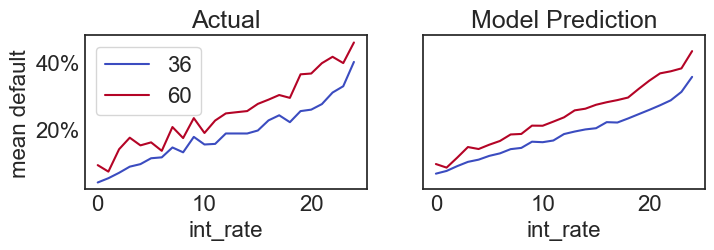

In [60]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
figsize=(8,2)
    
train_samp_agg_plot[[c for c in train_samp_agg_plot.columns if c[0] == 'target_mean']] \
    .droplevel(0, axis=1) \
    .plot(color=colors, legend=None, figsize=figsize, ax=ax[0])
train_samp_agg_plot[[c for c in train_samp_agg_plot.columns if c[0] == 'predict_mean']] \
    .droplevel(0, axis=1) \
    .plot(color=colors, legend=None, figsize=figsize, ax=ax[1])     

ax[0].legend(frameon=True)
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax[1].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax[1].set_xlabel('int_rate')
ax[0].set_xlabel('int_rate')
ax[0].set_ylabel('mean default')
ax[0].title.set_text('Actual')
ax[1].title.set_text('Model Prediction')
fig.savefig(Path(setup.temp_path).joinpath('06_PLOT_int_term_actual_pred.png'),
            bbox_inches='tight')

## PDP / ICE Plots - Term and Interest Rate

##### 2-Way PDP Average

In [61]:
# Get 2-Way PDP
avg_pdp = partial_dependence(base_model, train_samp_df[predictor_features], 
                                  ['int_rate', 'term'], kind='average',
                             percentiles=(0,1),
                            method='brute')

In [62]:
# Convert to data frame
avg_pdp_df = pd.concat([pd.DataFrame(avg_pdp['values'][0], columns=['values']),
                         pd.DataFrame(avg_pdp['average'][0], columns=avg_pdp['values'][1])],
                        axis=1)

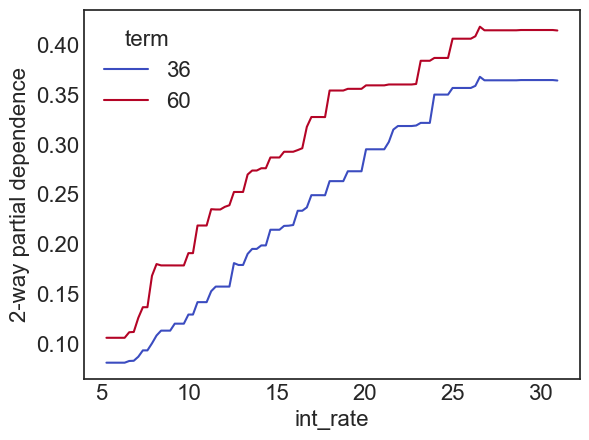

In [63]:
# Plot
fig, ax = plt.subplots()
avg_pdp_df.set_index('values').plot(color = colors, ax=ax)
ax.set_ylabel('2-way partial dependence')
ax.set_xlabel('int_rate')
ax.legend(title='term')
fig.savefig(Path(setup.temp_path).joinpath('06_PLOT_int_term_pdp_avg.png'),
            bbox_inches='tight')

##### Overlay 1-Way Averages

In [64]:
term_value_counts = train_samp_df['term'].value_counts()
color_categories = term_value_counts.index
cnorm  = mpl.colors.Normalize(vmin=0, vmax= len(color_categories) - 1)
color_scalar_map = mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap)
color_dict = {color_categories[i]: color_scalar_map.to_rgba(i) 
              for i in range(0, len(color_categories))}

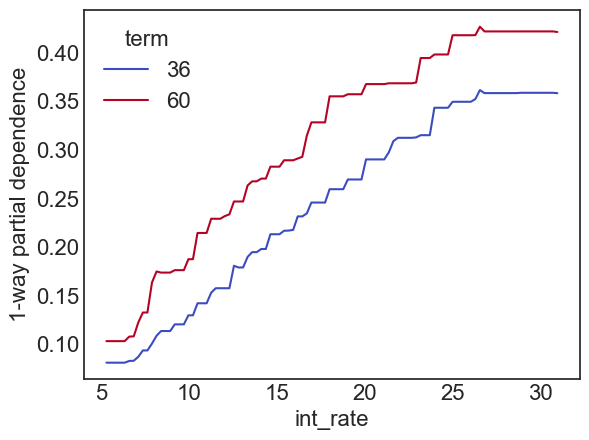

In [65]:
fig, ax = plt.subplots()

for key, group in train_samp_df.groupby('term'):
    this_pdp = partial_dependence(base_model, group[predictor_features], 
                                  ['int_rate'], kind='average',
                                 percentiles=(0,1),
                                 method='brute')
    this_pdp_df = pd.DataFrame({k:v[0] for k,v in this_pdp.items()})
    
    this_pdp_df.plot(x='values', y='average', ax=ax,
                     color=color_dict[key], label=key)
ax.set_ylabel('1-way partial dependence')
ax.set_xlabel('int_rate')
ax.legend(title='term')
fig.savefig(Path(setup.temp_path).joinpath('06_PLOT_int_term_pdp_avg_double_1way.png'),
            bbox_inches='tight')

##### 2-Way ICE Curves (Sample)

In [66]:
# Get stratified samp - large sample to ensure adequate grid size
X_samp = train_samp_df[predictor_features].groupby('term').sample(100)

In [67]:
# Get 2-Way PDP
indiv_pdp = partial_dependence(base_model, X_samp, 
                                  ['int_rate', 'term'], kind='individual',
                               percentiles=(0,1),
                              method='brute',
                              grid_resolution = 100)

In [68]:
# DataFrame conversion 
num_samp = indiv_pdp['individual'][0].shape[0]
indiv_samp_df = pd.concat([pd.DataFrame(indiv_pdp['individual'][0][i,:,:],
                                   columns = indiv_pdp['values'][1]) \
                           for i in range(0, num_samp)],
                     keys = range(0, num_samp),
                     axis=1)

In [69]:
indiv_samp_df.index = pd.Series(indiv_pdp['values'][0], name='values')

In [70]:
indiv_samp_df.shape

(100, 400)

In [71]:
random.seed(43)
colsamp = random.sample(list(indiv_samp_df.columns.get_level_values(0)), 10)

In [72]:
# Get subsample of cases to make plots nicer
colsamp = random.sample(list(indiv_samp_df.columns.get_level_values(0)), 20)
indiv_samp_2_df = indiv_samp_df.loc[:, colsamp]

In [73]:
indiv_samp_2_df.shape

(100, 40)

In [74]:
# Plot - panel, show side by side

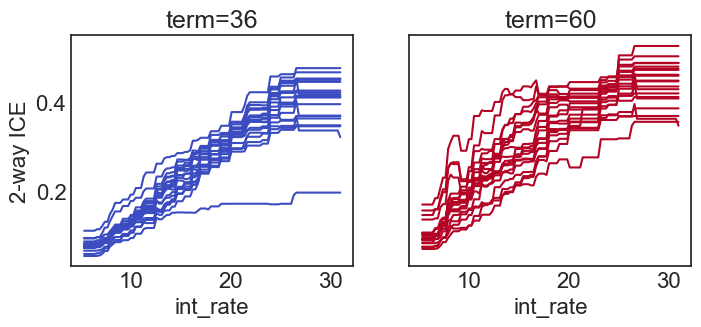

In [75]:
fig, ax = plt.subplots(1, 2, sharex = True, sharey=True,
                      figsize = (8,3))

for i, tv in enumerate(set(indiv_samp_2_df.columns.get_level_values(1))):
    this_df = indiv_samp_2_df.loc[:, indiv_samp_2_df.columns.get_level_values(1)==tv]
    this_df.plot(color=color_dict[tv],  ax=ax[i], legend=None)
    ax[i].set_xlabel('int_rate')
    ax[i].set_title(f'term={tv}')

ax[0].set_ylabel('2-way ICE')
fig.savefig(Path(setup.temp_path).joinpath('06_PLOT_int_term_ice_samples_panel.png'),
            bbox_inches='tight')